# ResearchLens: GNNs for Node Classification and Influence Prediction in Research Citation Networks

## Node Classification

In [ ]:
from ogb.nodeproppred import NodePropPredDataset, Evaluator
from torch_geometric.nn import GCNConv, BatchNorm
from sklearn.preprocessing import StandardScaler
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
from sklearn.manifold import TSNE
from tqdm import tqdm

import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
import torch

In [ ]:
class EnhancedGCN(torch.nn.Module):
    """
    Enhanced Graph Convolutional Network (GCN) for node classification in citation networks.
    This network can handle multiple hidden layers and includes batch normalization for better training.
    """
    def __init__(self, input_dim, hidden_dims, output_dim, dropout=0.5, use_batch_norm=True):
        super(EnhancedGCN, self).__init__()
        
        # Save dropout rate and batch norm flag for later use
        self.dropout        = dropout         # How much to randomly "turn off" during training (prevents overfitting)
        self.use_batch_norm = use_batch_norm  # Whether to normalize layer outputs (helps training)
        self.layers         = torch.nn.ModuleList()
        
        # First layer: Transform input features to first hidden dimension
        self.layers.append(GCNConv(input_dim, hidden_dims[0]))
        if use_batch_norm:
            self.batch_norms = torch.nn.ModuleList([BatchNorm(hidden_dims[0])])
        
        # Create middle (hidden) layers
        # Example: If hidden_dims=[128, 64], this creates a layer from 128->64
        for i in range(len(hidden_dims) - 1):
            self.layers.append(GCNConv(hidden_dims[i], hidden_dims[i + 1]))
            if use_batch_norm:
                self.batch_norms.append(BatchNorm(hidden_dims[i + 1]))
        
        # Final layer: Transform last hidden dim to output size (number of classes)
        self.layers.append(GCNConv(hidden_dims[-1], output_dim))

    def forward(self, x, edge_index):
        """
        Forward pass of the network.
        x: Node features
        edge_index: Graph connectivity in COO format
        """
        # Process all layers except the last one
        for i, conv in enumerate(self.layers[:-1]):
            # Apply graph convolution
            x = conv(x, edge_index)
            
            # Apply batch normalization if enabled
            if self.use_batch_norm:
                x = self.batch_norms[i](x)
            
            # Apply ReLU activation
            x = F.relu(x)
            
            # Apply dropout
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Final layer: no activation/dropout, just transform and apply log_softmax
        x = self.layers[-1](x, edge_index)
        return F.log_softmax(x, dim=1)  # Convert to probabilities (log space)
    
    def get_embeddings(self, x, edge_index):
        """
        Get node embeddings from the second-to-last layer.
        Used for visualization and analyzing node representations.
        """
        for i, conv in enumerate(self.layers[:-1]):
            x = conv(x, edge_index)
            if self.use_batch_norm:
                x = self.batch_norms[i](x)
            x = F.relu(x)
        return x

In [ ]:
class CitationNetworkTrainer:
    """
    A trainer class that handles everything related to training and evaluating our GCN model 
    on citation network datasets (Cora and ogbn-arxiv).
    """
    
    def __init__(self, dataset_name, hidden_dims=[256, 128], dropout=0.5):
        """
        Initialize trainer with model hyperparameters
        - hidden_dims : List of neural network layer sizes
        - dropout     : Probability of dropping connections during training
        """
        self.dataset_name = dataset_name
        self.hidden_dims  = hidden_dims
        self.dropout      = dropout

        # Use GPU if available, otherwise CPU
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.load_dataset()  # Load dataset first
        self.setup_model()   # Then set up the model
        
    def load_dataset(self):
        """
        Load either Cora or ogbn-arxiv dataset.
        Handles the different formats of each dataset.
        """
        if self.dataset_name.lower() == 'cora':
            # Cora is simpler to load - comes with PyTorch Geometric
            dataset          = Planetoid(root='/tmp/Cora', name='Cora')
            self.data        = dataset[0]           # Get the first (and only) graph
            self.num_classes = dataset.num_classes
            self.evaluator   = None                 # Cora uses simple accuracy evaluation
            
        else:  # ogbn-arxiv
            # ogbn-arxiv requires more preprocessing
            dataset = NodePropPredDataset(name="ogbn-arxiv")
            data    = dataset[0]
            
            # Convert data to PyTorch tensors with appropriate types
            edge_index = torch.tensor(data[0]["edge_index"], dtype=torch.long)
            x = torch.tensor(data[0]["node_feat"], dtype=torch.float)
            y = torch.tensor(data[1], dtype=torch.long)
            
            # Create PyG Data object
            self.data = Data(x=x, edge_index=edge_index, y=y)
            
            # Create masks for train/val/test split
            split_idx = dataset.get_idx_split()

            # Initialize masks as all False
            self.data.train_mask = torch.zeros(self.data.x.size(0), dtype=torch.bool)
            self.data.val_mask   = torch.zeros(self.data.x.size(0), dtype=torch.bool)
            self.data.test_mask  = torch.zeros(self.data.x.size(0), dtype=torch.bool)
            
            # Set True for nodes in each split
            self.data.train_mask[split_idx["train"]] = True
            self.data.val_mask[split_idx["valid"]]   = True
            self.data.test_mask[split_idx["test"]]   = True
            
            self.num_classes = dataset.num_classes
            self.evaluator   = Evaluator(name="ogbn-arxiv")  # Special evaluator for ogbn-arxiv
        
        # Move data to GPU if available
        self.data = self.data.to(self.device)
        
        # Print dataset statistics
        print(f"\nDataset          : {self.dataset_name}")
        print(f"Number of nodes    : {self.data.x.size(0)}")
        print(f"Number of features : {self.data.x.size(1)}")
        print(f"Number of classes  : {self.num_classes}")
        print(f"Number of edges    : {self.data.edge_index.size(1) // 2}")

    def setup_model(self):
        """
        Initialize the GNN model, optimizer, and learning rate scheduler
        """
        # Create model and move to GPU if available
        self.model = EnhancedGCN(
            input_dim   = self.data.x.size(1),  # Number of input features
            hidden_dims = self.hidden_dims,     # Size of hidden layers
            output_dim  = self.num_classes,     # Number of classes to predict
            dropout     = self.dropout
        ).to(self.device)
        
        # Adam optimizer with standard parameters
        self.optimizer = torch.optim.Adam(
            self.model.parameters(), 
            lr           = 0.01,    # Learning rate
            weight_decay = 5e-4     # L2 regularization
        )
        
        # Reduce learning rate when validation accuracy plateaus
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode     = 'max',   # Look for maximum validation accuracy
            factor   = 0.5,     # Multiply learning rate by 0.5 when plateauing
            patience = 10,      # Wait 10 epochs before reducing
            min_lr   = 1e-5     # Don't go below this learning rate
        )

    def train_epoch(self):
        """
        Train for one epoch (one pass through the training data)
        """
        self.model.train()          # Set model to training mode
        self.optimizer.zero_grad()  # Clear previous gradients
        
        # Get model predictions
        out = self.model(self.data.x, self.data.edge_index)
        # Compute loss only on training nodes
        loss = F.nll_loss(
            out[self.data.train_mask], 
            self.data.y[self.data.train_mask].squeeze()
        )
        
        # Backpropagation
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    @torch.no_grad()  # Not tracking gradients during evaluation
    def evaluate(self):
        """
        Evaluate model performance on train/validation/test sets
        Different evaluation methods for Cora vs ogbn-arxiv
        """
        self.model.eval()  # Set model to evaluation mode
        out = self.model(self.data.x, self.data.edge_index)
        
        if self.evaluator is not None:  # ogbn-arxiv
            # Use official OGB evaluator
            y_pred = out.argmax(dim=1).unsqueeze(-1)
            y_true = self.data.y.squeeze(-1)
            
            # Compute accuracy for each set using OGB evaluator
            train_acc = self.evaluator.eval({
                "y_true": y_true[self.data.train_mask].unsqueeze(-1),
                "y_pred": y_pred[self.data.train_mask],
            })["acc"]
            
            valid_acc = self.evaluator.eval({
                "y_true": y_true[self.data.val_mask].unsqueeze(-1),
                "y_pred": y_pred[self.data.val_mask],
            })["acc"]
            
            test_acc = self.evaluator.eval({
                "y_true": y_true[self.data.test_mask].unsqueeze(-1),
                "y_pred": y_pred[self.data.test_mask],
            })["acc"]
        else:  # Cora
            pred = out.argmax(dim=1)
            train_acc = (pred[self.data.train_mask] == self.data.y[self.data.train_mask]).float().mean().cpu()
            valid_acc = (pred[self.data.val_mask]   == self.data.y[self.data.val_mask]).float().mean().cpu()
            test_acc  = (pred[self.data.test_mask]  == self.data.y[self.data.test_mask]).float().mean().cpu()
        
        return train_acc, valid_acc, test_acc

    def train(self, epochs=200, early_stopping_patience=20):
        """
        Main training loop with early stopping
        Returns training history for plotting
        """
        best_val_acc     = 0
        patience_counter = 0
        train_metrics    = []  # Store (loss, accuracy) pairs
        val_metrics      = []    # Store validation accuracies
        
        for epoch in tqdm(range(epochs), desc=f"Training {self.dataset_name}"):
            # Train one epoch and get loss
            loss = self.train_epoch()
            
            # Evaluate on train/val/test
            train_acc, valid_acc, test_acc = self.evaluate()
            
            # Store metrics (handle both tensor and float cases)
            if isinstance(train_acc, torch.Tensor):
                train_metrics.append((loss, train_acc.cpu()))
                val_metrics.append(valid_acc.cpu())
            else:
                train_metrics.append((loss, train_acc))
                val_metrics.append(valid_acc)
            
            # Adjust learning rate based on validation performance
            self.scheduler.step(valid_acc)
            
            # Print progress every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
                      f"Train: {train_acc:.4f}, Val: {valid_acc:.4f}, "
                      f"Test: {test_acc:.4f}")
            
            # Early stopping check
            if valid_acc > best_val_acc:
                best_val_acc = valid_acc
                # Save best model
                torch.save(self.model.state_dict(), f'best_model_{self.dataset_name}.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered!")
                    break
        
        # Load best model and get final results
        self.model.load_state_dict(torch.load(f'best_model_{self.dataset_name}.pt'))
        train_acc, valid_acc, test_acc = self.evaluate()
        print(f"\nFinal results for {self.dataset_name}:")
        print(f"Train: {train_acc:.4f}")
        print(f"Validation: {valid_acc:.4f}")
        print(f"Test: {test_acc:.4f}")
        
        return train_metrics, val_metrics

    def visualize_embeddings(self, num_samples=5000):
        """
        Visualize node embeddings using t-SNE
        Colors nodes by their class
        """
        self.model.eval()
        with torch.no_grad():
            # Get node embeddings from second-to-last layer
            embeddings = self.model.get_embeddings(self.data.x, self.data.edge_index)
            
        # Sample nodes if there are too many
        if embeddings.size(0) > num_samples:
            idx        = np.random.choice(embeddings.size(0), num_samples, replace=False)
            embeddings = embeddings[idx].cpu().numpy()
            labels     = self.data.y[idx].cpu().numpy()
        else:
            embeddings = embeddings.cpu().numpy()
            labels     = self.data.y.cpu().numpy()
        
        # Use t-SNE to reduce dimensionality to 2D
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)
        
        # Create scatter plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                            c=labels, cmap='tab20', s=10)
        plt.colorbar(scatter, label="Paper Category")
        plt.title(f"t-SNE Visualization of {self.dataset_name} Node Embeddings")
        plt.xlabel("t-SNE Dimension 1")
        plt.ylabel("t-SNE Dimension 2")
        plt.show()
    
    def plot_training_curves(self, train_metrics, val_metrics):
        """
        Plot training loss and accuracy curves
        """
        epochs = range(1, len(train_metrics) + 1)
        
        plt.figure(figsize=(12, 4))
        
        # Loss curve
        plt.subplot(1, 2, 1)
        plt.plot(epochs, [x[0] for x in train_metrics], label='Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'{self.dataset_name} Training Loss Over Time')
        plt.legend()
        
        # Accuracy curve
        plt.subplot(1, 2, 2)
        plt.plot(epochs, [x[1] for x in train_metrics], label='Train Acc')
        plt.plot(epochs, val_metrics, label='Validation Acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title(f'{self.dataset_name} Training and Validation Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

## Influence prediction

In [ ]:
class NodeInfluenceAnalyzer:
    """
    This class analyzes how influential each node is in our citation network.
    """
    def __init__(self, data, model, dataset_name):
        # Store basic information
        self.data         = data          # Our graph data
        self.model        = model         # Our trained GNN model
        self.dataset_name = dataset_name  # Which dataset we're analyzing
        self.device       = next(model.parameters()).device

        # Convert PyG graph to NetworkX for easier analysis
        self.G = to_networkx(data, to_undirected=True)  # Convert to undirected graph
    
    def compute_centrality_measures(self):
        """
        Compute different ways to measure how 'central' or important each node is.
        Kind of like measuring a paper's importance in different ways.
        """
        print(f"Computing centrality measures for {self.dataset_name}...")
        
        # Degree Centrality: How many direct connections does a node have?
        # Like counting how many papers directly cite/are cited by this paper
        degree_cent = nx.degree_centrality(self.G)
        
        # Eigenvector Centrality: Are you connected to other important nodes?
        # Like asking: does this paper cite/is cited by other important papers?
        eigenvector_cent = nx.eigenvector_centrality(self.G, max_iter=1000)
        
        # Betweenness Centrality: Are you a bridge between different communities?
        # For large graphs, we sample to save computation time
        if self.G.number_of_nodes() > 10000:
            # Use sampling for large graphs (like ogbn-arxiv)
            betweenness_cent = nx.betweenness_centrality(self.G, k=1000)
        else:
            # Compute exactly for smaller graphs (like Cora)
            betweenness_cent = nx.betweenness_centrality(self.G)
        
        # 4. PageRank: Google's algorithm for ranking web pages
        # Similar to eigenvector centrality but with some tweaks
        pagerank = nx.pagerank(self.G)
        
        # Store all metrics in a dictionary
        self.centrality_metrics = {
            'degree'     : np.array(list(degree_cent.values())),
            'eigenvector': np.array(list(eigenvector_cent.values())),
            'betweenness': np.array(list(betweenness_cent.values())),
            'pagerank'   : np.array(list(pagerank.values()))
        }
        
        return self.centrality_metrics
    
    def compute_influence_scores(self):
        """
        Simplified influence score computation for large graphs
        Combines centrality metrics without computing full similarity matrix
        """
        print("Computing influence scores...")
        
        # Get node embeddings from our trained model
        self.model.eval()
        with torch.no_grad():
            embeddings = self.model.get_embeddings(self.data.x, self.data.edge_index)
            embeddings = embeddings.cpu().numpy()
        
        # Instead of full similarity matrix, just compute embedding magnitudes
        embedding_importance = np.linalg.norm(embeddings, axis=1)
        
        # Normalize centrality measures
        scaler = StandardScaler()
        centrality_matrix = np.column_stack([
            scaler.fit_transform(self.centrality_metrics[metric].reshape(-1, 1)).flatten()
            for metric in self.centrality_metrics.keys()
        ])
        
        # Combine centrality with embedding importance
        # This avoids computing the full similarity matrix
        influence_scores = np.mean(centrality_matrix, axis=1) * embedding_importance
        
        # Normalize final scores
        influence_scores = (influence_scores - influence_scores.min()) / (influence_scores.max() - influence_scores.min())
        
        return influence_scores

    def visualize_influence_distribution(self, influence_scores):
        """
        Show how influence scores are distributed and who the top papers are
        """
        # Plot distribution of scores
        plt.figure(figsize=(10, 6))
        sns.histplot(influence_scores, bins=50, kde=True)
        plt.title(f'{self.dataset_name} Node Influence Score Distribution')
        plt.xlabel('Influence Score')
        plt.ylabel('Count')
        plt.show()
        
        # Print top 10 most influential nodes
        top_k = min(10, len(influence_scores))
        top_indices = np.argsort(influence_scores)[-top_k:][::-1]
        print(f"\nTop {top_k} influential nodes in {self.dataset_name}:")
        for i, idx in enumerate(top_indices, 1):
            print(f"{i}. Node {idx}: Influence Score = {influence_scores[idx]:.4f}")
    
    def visualize_centrality_correlations(self):
        """
        Show how different centrality measures relate to each other
        """
        centrality_df = pd.DataFrame(self.centrality_metrics)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(centrality_df.corr(), annot=True, cmap='coolwarm', center=0)
        plt.title(f'{self.dataset_name} Centrality Measures Correlation')
        plt.show()
    
    def analyze_influence_propagation(self, start_nodes=None, num_steps=3):
        """
        Analyze how influence spreads through the network
        Like watching how information flows from important papers!
        """
        if start_nodes is None:
            # Start from the 5 most influential nodes
            influence_scores = self.compute_influence_scores()
            start_nodes = np.argsort(influence_scores)[-5:]
        
        # Track how influence spreads
        propagation_results = []
        for start_node in start_nodes:
            visited = set([start_node])        # Nodes we've reached
            current_layer = {start_node}       # Current frontier
            propagation = []                   # Track spread at each step
            
            # For each step
            for step in range(num_steps):
                next_layer = set()  # Who we'll reach next
                # For each node in current layer
                for node in current_layer:
                    # Find its unvisited neighbors
                    neighbors = set(self.G.neighbors(node)) - visited
                    next_layer.update(neighbors)    # Add to next layer
                    visited.update(neighbors)       # Mark as visited
                
                propagation.append(len(next_layer))  # Record how many new nodes
                current_layer = next_layer           # Move to next layer
                
                if not current_layer:  # Stop if no more nodes to visit
                    break
            
            propagation_results.append(propagation)
        
        # Visualize how influence spreads
        plt.figure(figsize=(10, 6))
        for i, prop in enumerate(propagation_results):
            plt.plot(range(len(prop)), prop, marker='o', label=f'Node {start_nodes[i]}')
        
        plt.title(f'{self.dataset_name} Influence Propagation')
        plt.xlabel('Steps')
        plt.ylabel('Number of Newly Influenced Nodes')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        return propagation_results

In [33]:
def analyze_node_influence(trainer):
    """Main function to analyze node influence"""
    print(f"\nAnalyzing node influence for {trainer.dataset_name}...")
    
    analyzer = NodeInfluenceAnalyzer(trainer.data, trainer.model, trainer.dataset_name)
    
    # Compute centrality measures
    centrality_metrics = analyzer.compute_centrality_measures()
    
    # Visualize centrality correlations
    analyzer.visualize_centrality_correlations()
    
    # Compute and visualize influence scores
    influence_scores = analyzer.compute_influence_scores()
    analyzer.visualize_influence_distribution(influence_scores)
    
    # Analyze influence propagation
    analyzer.analyze_influence_propagation()
    
    return analyzer


Training Cora dataset...

Dataset          : Cora
Number of nodes    : 2708
Number of features : 1433
Number of classes  : 7
Number of edges    : 5278


Training Cora:   2%|▏         | 4/200 [00:00<00:05, 38.12it/s]

Epoch 000, Loss: 2.1665, Train: 0.9357, Val: 0.7000, Test: 0.6940


Training Cora:  12%|█▎        | 25/200 [00:00<00:02, 60.75it/s]

Epoch 010, Loss: 0.0339, Train: 1.0000, Val: 0.7480, Test: 0.7600
Epoch 020, Loss: 0.0091, Train: 1.0000, Val: 0.7400, Test: 0.7580
Early stopping triggered!

Final results for Cora:
Train: 0.9929
Validation: 0.7760
Test: 0.7660


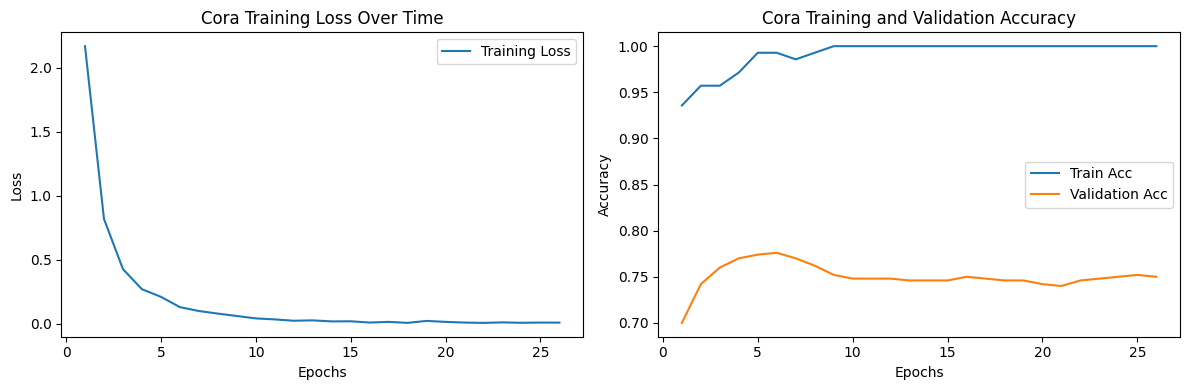

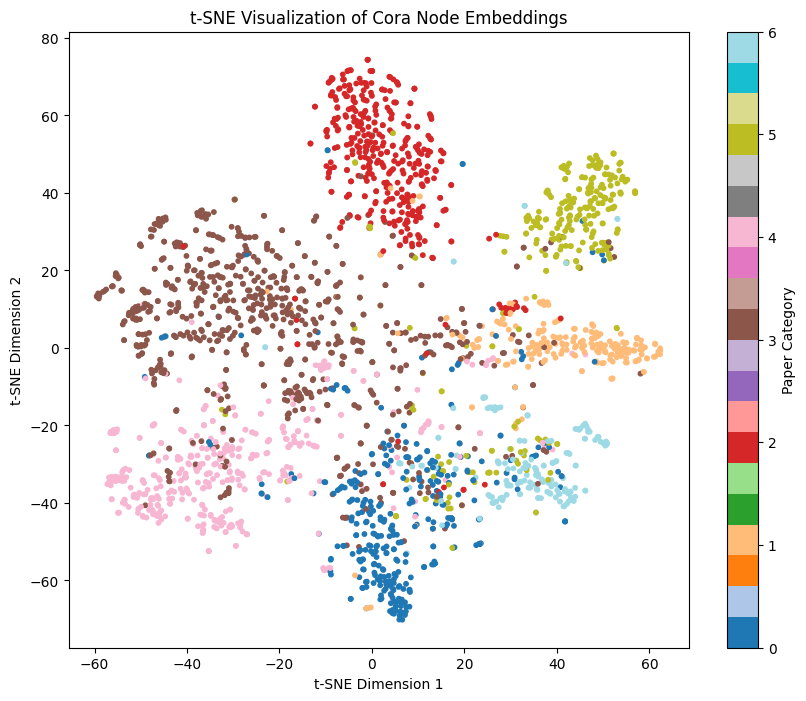


Analyzing node influence for Cora...
Computing centrality measures for Cora...


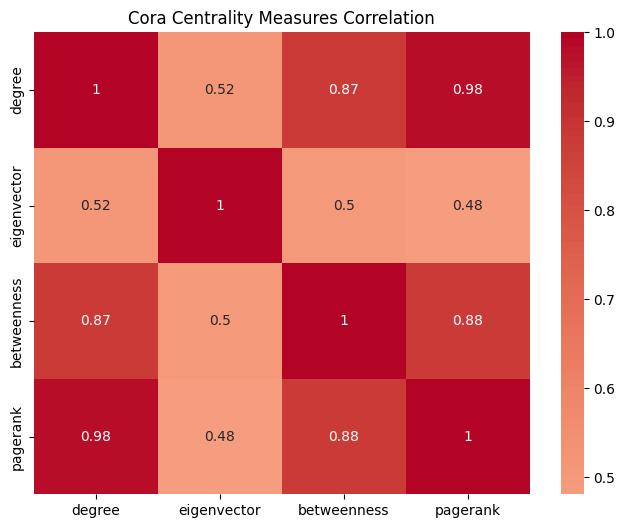

Computing influence scores...


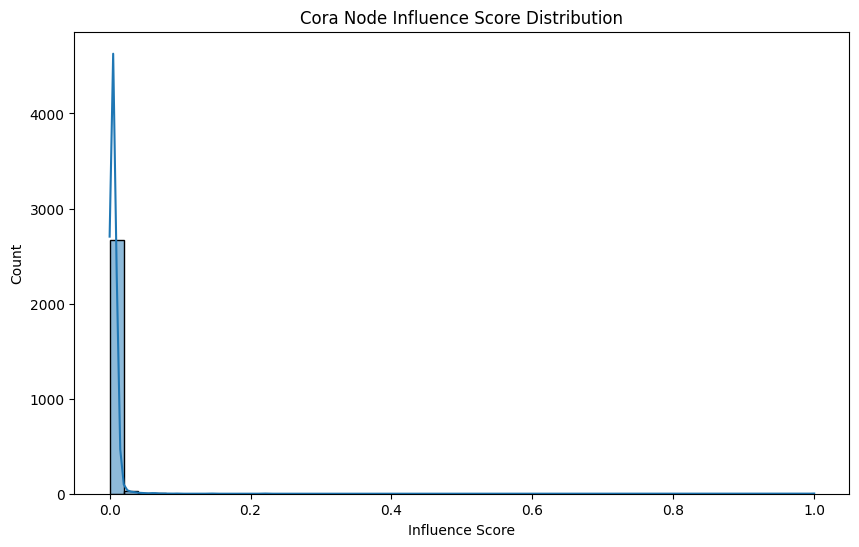


Top 10 influential nodes in Cora:
1. Node 1358: Influence Score = 1.0000
2. Node 306: Influence Score = 0.2205
3. Node 1701: Influence Score = 0.1438
4. Node 1986: Influence Score = 0.0952
5. Node 1623: Influence Score = 0.0766
6. Node 2034: Influence Score = 0.0656
7. Node 1810: Influence Score = 0.0642
8. Node 109: Influence Score = 0.0604
9. Node 88: Influence Score = 0.0604
10. Node 1072: Influence Score = 0.0500
Computing influence scores...


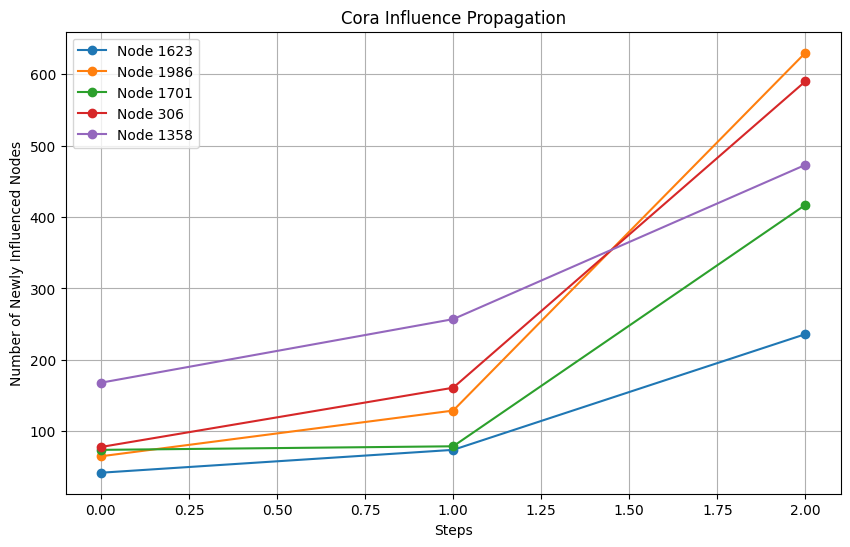


Training ogbn-arxiv dataset...

Dataset          : ogbn-arxiv
Number of nodes    : 169343
Number of features : 128
Number of classes  : 40
Number of edges    : 583121


Training ogbn-arxiv:   0%|          | 1/200 [00:00<01:29,  2.22it/s]

Epoch 000, Loss: 4.0925, Train: 0.1067, Val: 0.0802, Test: 0.0971


Training ogbn-arxiv:   6%|▌         | 11/200 [00:02<00:42,  4.43it/s]

Epoch 010, Loss: 1.9574, Train: 0.4367, Val: 0.4616, Test: 0.4219


Training ogbn-arxiv:  10%|█         | 21/200 [00:04<00:40,  4.44it/s]

Epoch 020, Loss: 1.7431, Train: 0.5441, Val: 0.5345, Test: 0.4839


Training ogbn-arxiv:  16%|█▌        | 31/200 [00:07<00:38,  4.43it/s]

Epoch 030, Loss: 1.6341, Train: 0.5723, Val: 0.5600, Test: 0.5066


Training ogbn-arxiv:  20%|██        | 41/200 [00:09<00:35,  4.48it/s]

Epoch 040, Loss: 1.5673, Train: 0.5922, Val: 0.5704, Test: 0.5054


Training ogbn-arxiv:  26%|██▌       | 51/200 [00:11<00:33,  4.43it/s]

Epoch 050, Loss: 1.5188, Train: 0.5984, Val: 0.5819, Test: 0.5252


Training ogbn-arxiv:  30%|███       | 61/200 [00:13<00:31,  4.44it/s]

Epoch 060, Loss: 1.4799, Train: 0.6036, Val: 0.5887, Test: 0.5326


Training ogbn-arxiv:  36%|███▌      | 71/200 [00:16<00:28,  4.48it/s]

Epoch 070, Loss: 1.4525, Train: 0.6060, Val: 0.5876, Test: 0.5339


Training ogbn-arxiv:  40%|████      | 81/200 [00:18<00:26,  4.48it/s]

Epoch 080, Loss: 1.4256, Train: 0.6160, Val: 0.5855, Test: 0.5288


Training ogbn-arxiv:  46%|████▌     | 91/200 [00:20<00:24,  4.50it/s]

Epoch 090, Loss: 1.4201, Train: 0.6255, Val: 0.5931, Test: 0.5326


Training ogbn-arxiv:  50%|█████     | 101/200 [00:22<00:22,  4.48it/s]

Epoch 100, Loss: 1.4051, Train: 0.6324, Val: 0.5960, Test: 0.5375


Training ogbn-arxiv:  56%|█████▌    | 111/200 [00:25<00:19,  4.46it/s]

Epoch 110, Loss: 1.3896, Train: 0.6363, Val: 0.5997, Test: 0.5382


Training ogbn-arxiv:  60%|██████    | 121/200 [00:27<00:17,  4.47it/s]

Epoch 120, Loss: 1.3845, Train: 0.6397, Val: 0.6013, Test: 0.5421


Training ogbn-arxiv:  66%|██████▌   | 131/200 [00:29<00:15,  4.47it/s]

Epoch 130, Loss: 1.3758, Train: 0.6431, Val: 0.6003, Test: 0.5404


Training ogbn-arxiv:  70%|███████   | 141/200 [00:31<00:13,  4.48it/s]

Epoch 140, Loss: 1.3713, Train: 0.6464, Val: 0.6014, Test: 0.5414


Training ogbn-arxiv:  74%|███████▍  | 149/200 [00:33<00:11,  4.41it/s]

Early stopping triggered!

Final results for ogbn-arxiv:
Train: 0.6430
Validation: 0.6017
Test: 0.5427


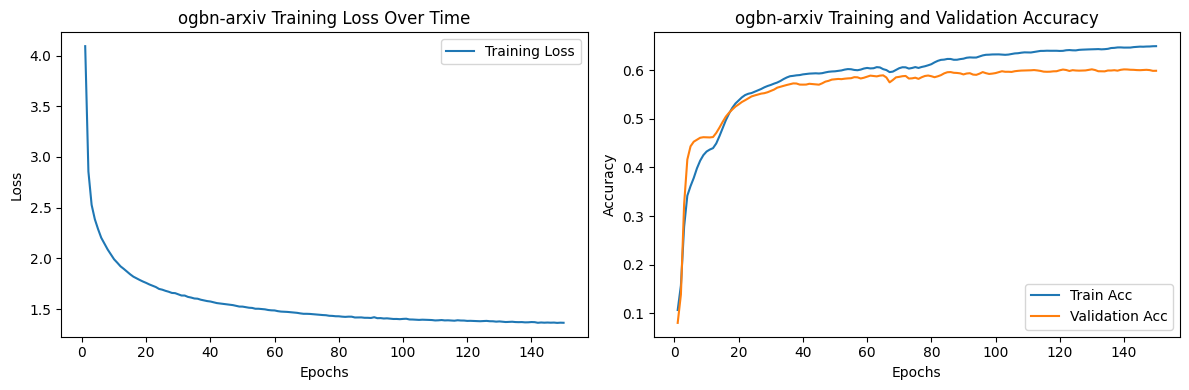

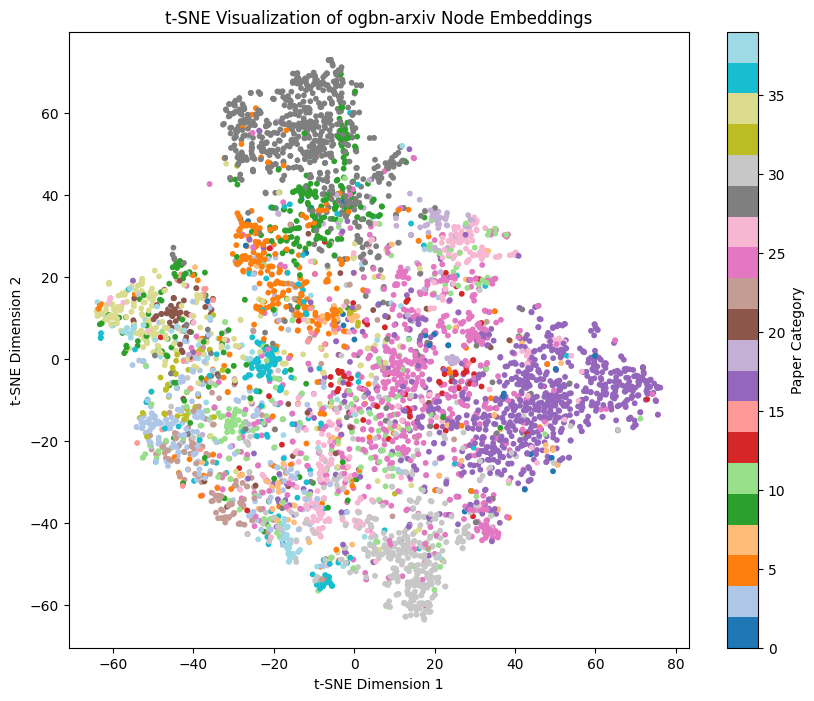


Analyzing node influence for ogbn-arxiv...
Computing centrality measures for ogbn-arxiv...


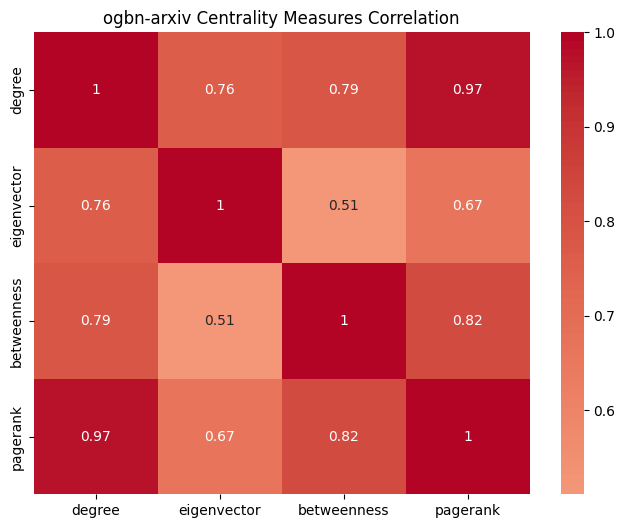

Computing influence scores...


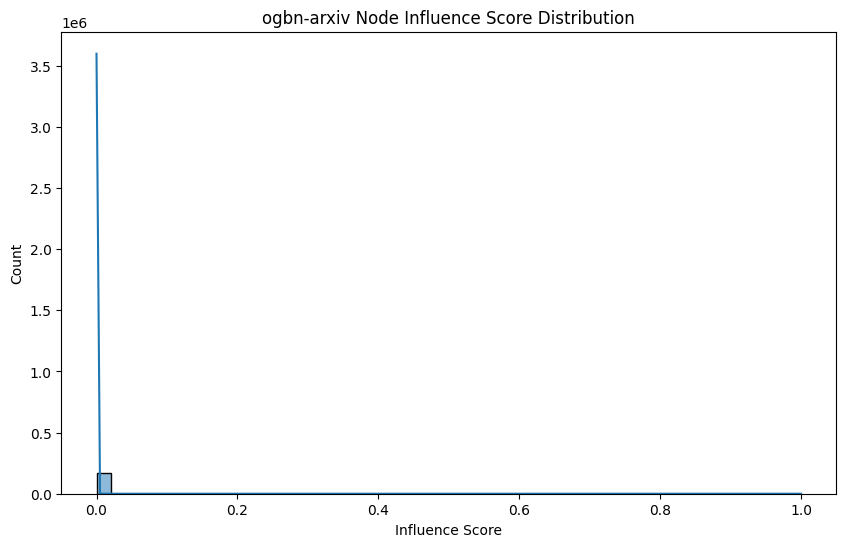


Top 10 influential nodes in ogbn-arxiv:
1. Node 1353: Influence Score = 1.0000
2. Node 67166: Influence Score = 0.8919
3. Node 25208: Influence Score = 0.5622
4. Node 69794: Influence Score = 0.2078
5. Node 93649: Influence Score = 0.1837
6. Node 22035: Influence Score = 0.1612
7. Node 115359: Influence Score = 0.1600
8. Node 106699: Influence Score = 0.1516
9. Node 133376: Influence Score = 0.1507
10. Node 166425: Influence Score = 0.1444
Computing influence scores...


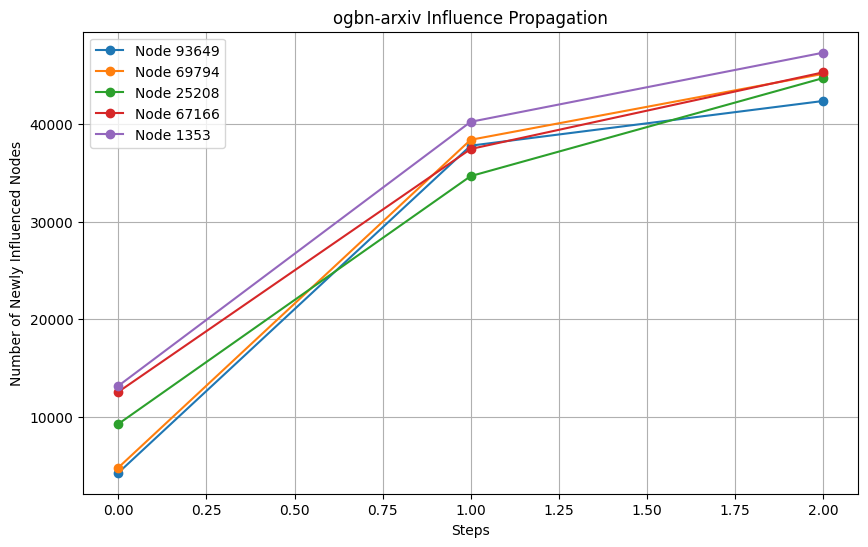

In [34]:
def main():
    # Hyperparameters for each dataset
    dataset_configs = {
        'Cora': {
            'hidden_dims': [128, 64],  # Smaller architecture for Cora
            'dropout': 0.5
        },
        'ogbn-arxiv': {
            'hidden_dims': [256, 128],  # Larger architecture for ogbn-arxiv
            'dropout': 0.5
        }
    }
    
    # Train both datasets
    for dataset_name, config in dataset_configs.items():
        print(f"\nTraining {dataset_name} dataset...")
        trainer = CitationNetworkTrainer(
            dataset_name=dataset_name,
            hidden_dims=config['hidden_dims'],
            dropout=config['dropout']
        )
        
        # Train the model
        train_metrics, val_metrics = trainer.train(epochs=200, early_stopping_patience=20)
        
        # Generate visualizations
        trainer.plot_training_curves(train_metrics, val_metrics)
        trainer.visualize_embeddings()
        
        # Add node influence analysis
        analyzer = analyze_node_influence(trainer)

if __name__ == "__main__":
    main()